# Masterthesis
## Regression

#### Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import RandomizedSearchCV, KFold 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
import matplotlib.pyplot as plt
from scipy import stats

Using TensorFlow backend.


In [2]:
na_values = ['nan', 'N/A', 'NaN', 'NaT']

In [3]:
df = pd.read_csv('resources/accident_data.csv', sep=";", na_values=na_values, index_col=False, dtype = {"STATE" : "str", "TYPE" : "str", "TYPEQ" : "str", "WEATHER" : "str", "VISIBLTY" : "str", "SPD_TOO_HIGH" : "str"})
df.shape[0]

70555

In [4]:
df=df.dropna(subset=['INFRASTRUCTURE_DMG', 'YEAR4', 'LOCOMOTIVES1', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2', 'LOADF2', 'EMPTYF2', 'TONS', 'TEMP_CLUSTER', 'SPEED', 'ACCCAUSE_LVL1', 'TYPE', 'EQUIPMENT_TYPE', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'STATE', 'SPD_TOO_HIGH', 'ACCTYPE', 'ACCIDENT_TYPE', 'Jahreszeit'])

In [5]:
std_dev = 3.5
df = df[(np.abs(stats.zscore(df[['LOCOMOTIVES1','LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2','LOADF2', 'EMPTYF2', 'INFRASTRUCTURE_DMG']])) < float(std_dev)).all(axis=1)]

In [6]:
pd.set_option('display.max_columns', 500)
#df.head(50)

In [7]:
df[df['TONS']==0].shape[0]

1901

In [8]:
df[df['SPEED']==0].shape[0]

993

In [9]:
df[df['INFRASTRUCTURE_DMG']==0].shape[0]

0

In [10]:
df.head(50)

,INCDTNO,MONTH,DAY,TYPE,STATE,TEMP,VISIBLTY,WEATHER,TRNSPD,TONS,TYPEQ,TRKCLAS,TYPTRK,HEADEND1,MIDMAN1,MIDREM1,RMAN1,RREM1,HEADEND2,MIDMAN2,MIDREM2,RMAN2,RREM2,LOADF1,LOADP1,EMPTYF1,EMPTYP1,LOADF2,LOADP2,EMPTYF2,EMPTYP2,EQPDMG,TRKDMG,ACCAUSE,HIGHSPD,ACCDMG,YEAR4,RREMPKLD,RREMPINJ,PASSKLD,PASSINJ,OTHERKLD,OTHERINJ,ACCIDENT_TYPE,ACCCAUSE_LVL1,ACCCAUSE_LVL2,LOCOMOTIVES1,LOCOMOTIVES2,SPEED,INFRASTRUCTURE_DMG,ACCDMG_EUR,ACCTYPE,TEMP_CLUSTER,SPD_TOO_HIGH,Jahreszeit,EQUIPMENT_TYPE
0,LA1904,9,27,01,Minnesota,50,Dark,Clear,5.0,7100.000000,1,1,Yard,2.0,0,0,0,0,0,0,0,0,0,56,0,56,0,0,0,3,0,1000.0,15500.0,H999,5,16500,1990,0,0,0,0,0,0,Derailment,Miscellaneous,Human Factors,2,0,5.0,16500.0,13996.098058,Not Significant,"Moderat (0° bis 19,99° C)",False,Herbst,Freight Train
1,RE902,12,28,01,Alabama,40,Day,Cloudy,6.0,4329.667333,7,1,Industry,0.0,0,0,2,0,0,0,0,0,0,37,0,1,0,3,0,0,0,5688.0,1076.0,T210,6,6764,1990,0,0,0,0,0,0,Derailment,"Rail, Joint Bar and Rail Anchoring","Track, Roadbed and Structures",2,0,6.0,6764.0,5737.551955,Not Significant,"Moderat (0° bis 19,99° C)",False,Winter,Yard/Switching
2,YKR0490,12,17,01,Pennsylvania,50,Day,Clear,5.0,250.000000,7,1,Industry,1.0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0.0,25000.0,T314,5,25000,1990,0,0,0,0,0,0,Derailment,"Frogs, Switches and Track Appliances","Track, Roadbed and Structures",1,0,5.0,25000.0,21206.209178,Not Significant,"Moderat (0° bis 19,99° C)",False,Herbst,Yard/Switching
3,G1693,12,11,01,Wisconsion,45,Dark,Fog,7.0,8744.000000,1,1,Yard,3.0,0,0,0,0,0,0,0,0,0,75,0,12,0,5,0,0,0,15800.0,15805.0,E64C,7,31605,1990,0,0,0,0,0,0,Derailment,Wheels,Mechanical and Electrical Failures,3,0,7.0,31605.0,26808.889643,Not Significant,"Moderat (0° bis 19,99° C)",False,Herbst,Freight Train
4,0530004,12,31,01,West Virginia,24,Day,Clear,4.0,2500.000000,1,1,Industry,3.0,0,0,0,0,0,0,0,0,0,35,0,16,0,3,0,0,0,3500.0,3000.0,T311,4,6500,1990,0,0,0,0,0,0,Derailment,"Frogs, Switches and Track Appliances","Track, Roadbed and Structures",3,0,4.0,6500.0,5513.614386,Not Significant,"Kalt (-30° - 0,01° C)",False,Winter,Freight Train
5,5,12,3,01,Alabama,60,Day,Rain,5.0,2400.000000,1,X,Main,3.0,0,0,0,0,0,0,0,0,0,54,0,7,0,8,0,0,0,50000.0,10000.0,T221,5,60000,1990,0,0,0,0,0,0,Derailment,"Rail, Joint Bar and Rail Anchoring","Track, Roadbed and Structures",3,0,5.0,60000.0,50894.902027,Not Significant,"Moderat (0° bis 19,99° C)",False,Herbst,Freight Train
6,8,12,21,01,Alabama,60,Day,Cloudy,8.0,1500.000000,1,X,Main,3.0,0,0,0,0,0,0,0,0,0,15,0,0,0,3,0,0,0,45000.0,20000.0,E40C,8,65000,1990,0,0,0,0,0,0,Derailment,Truck Components,Mechanical and Electrical Failures,3,0,8.0,65000.0,55136.143863,Not Significant,"Moderat (0° bis 19,99° C)",False,Winter,Freight Train
8,1290VB206,12,21,01,Kansas,25,Dark,Cloudy,4.0,409.489411,6,4,Yard,0.0,0,0,0,0,0,0,0,0,0,3,0,0,0,2,0,0,0,550.0,12800.0,H018,4,13350,1990,0,0,0,0,0,0,Derailment,"Brakes, Use of",Human Factors,0,0,4.0,13350.0,11324.115701,Not Significant,"Kalt (-30° - 0,01° C)",False,Winter,Cut of Cars
9,1290WH205,12,14,01,Kansas,38,Day,Cloudy,6.0,820.000000,1,3,Main,2.0,0,0,0,0,0,0,0,0,0,4,0,10,0,3,0,0,0,1600.0,24627.0,H704,6,26227,1990,0,0,0,0,0,0,Derailment,"Switches, Use of",Human Factors,2,0,6.0,26227.0,22247.009925,Not Significant,"Moderat (0° bis 19,99° C)",False,Herbst,Freight Train
10,1290WH208,12,20,01,Kansas,1,Day,Clear,38.0,6334.000000,1,3,Main,4.0,0,0,0,0,0,0,0,0,0,56,0,22,0,1,0,0,0,1500.0,8000.0,E61C,38,9500,1990,0,0,0,0,0,0,Derailment,Wheels,Mechanical and Electrical Failures,4,0,38.0,9500.0,8058.359488,Not Significant,"Kalt (-30° - 0,01° C)",False,Herbst,Freight Train


In [11]:
df.isnull().values.any()

True

In [12]:
df.isnull().sum()

INCDTNO                 0
MONTH                   0
DAY                     0
TYPE                    0
STATE                   0
TEMP                    0
VISIBLTY                0
WEATHER                 0
TRNSPD                247
TONS                    0
TYPEQ                   0
TRKCLAS                 0
TYPTRK                  0
HEADEND1                0
MIDMAN1                 0
MIDREM1                 0
RMAN1                   0
RREM1                   0
HEADEND2                0
MIDMAN2                 0
MIDREM2                 0
RMAN2                   0
RREM2                   0
LOADF1                  0
LOADP1                  0
EMPTYF1                 0
EMPTYP1                 0
LOADF2                  0
LOADP2                  0
EMPTYF2                 0
EMPTYP2                 0
EQPDMG                  0
TRKDMG                  0
ACCAUSE                 0
HIGHSPD                 0
ACCDMG                  0
YEAR4                   0
RREMPKLD                0
RREMPINJ    

## Vorbereitungen

Festlegen der abhängigen Variablen X und der vorherzusagenden Variable y

In [13]:
x_data = df[['YEAR4', 'LOCOMOTIVES1', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2', 'LOADF2', 'EMPTYF2', 'TONS', 'TEMP_CLUSTER', 'SPEED', 'ACCCAUSE_LVL1', 'TYPE', 'EQUIPMENT_TYPE', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'STATE', 'SPD_TOO_HIGH', 'ACCTYPE', 'ACCIDENT_TYPE', 'Jahreszeit']]
y = df['INFRASTRUCTURE_DMG']

#### Aufteilen der Daten in Train und Test Datensatz

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y, test_size=0.3)

In [15]:
# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

In [16]:
def prepare_inputs_One_Hot(x_train, x_test):
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(x_train)
    x_train_enc = ohe.transform(x_train)
    x_test_enc = ohe.transform(x_test)
    return x_train_enc, x_test_enc

In [17]:
cat = ['TEMP_CLUSTER', 'ACCCAUSE_LVL1', 'TYPE', 'EQUIPMENT_TYPE', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'STATE', 'SPD_TOO_HIGH', 'ACCTYPE', 'ACCIDENT_TYPE', 'Jahreszeit']

In [18]:
con = ['SPEED', 'TONS', 'LOCOMOTIVES1', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2', 'LOADF2', 'EMPTYF2', 'YEAR4']

In [19]:
#x_train_enc_cat, x_test_enc_cat = prepare_inputs(x_train[cat], x_test[cat])
x_train_enc_cat, x_test_enc_cat = prepare_inputs_One_Hot(x_train[cat], x_test[cat])

In [20]:
#cs = MinMaxScaler().fit(x_train[con])
cs = StandardScaler().fit(x_train[con])
x_train_enc_con = cs.transform(x_train[con])
x_test_enc_con = cs.transform(x_test[con])

In [21]:
X_train = np.hstack([x_train_enc_cat, x_train_enc_con])
X_test = np.hstack([x_test_enc_cat, x_test_enc_con])

In [22]:
n_features = X_train.shape[1]

## Sequential regression model

In [23]:
def create_model(learning_rate = 0.01, activation = 'relu'):
    seq_model = Sequential()
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    seq_model.add(Dense(32, activation = activation, input_shape=(n_features,)))
    seq_model.add(BatchNormalization())
    seq_model.add(Dense(64, activation = activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(128, activation = activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(64, activation = activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(32, activation = activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(1, activation = activation))
    seq_model.summary()
    seq_model.compile(optimizer=opt, loss='mse', metrics=['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'msle', 'mape'])
    return seq_model

In [24]:
model = KerasRegressor(build_fn = create_model)

In [25]:
params = {'activation': ["relu", "tanh", "sigmoid", "selu", "softmax"],'batch_size': [16, 32, 64], 'epochs': [50, 100, 300, 1000],'learning_rate': [0.01, 0.001, 0.0001]}

In [26]:
random_search = RandomizedSearchCV(model, param_distributions = params,cv = KFold(10))

In [27]:
#random_search_results = random_search.fit(X_train, y_train)

In [28]:
#print("Best Score: ",random_search_results.best_score_,"and Best Params: ",random_search_results.best_params_)

### Regression Allgemein

In [55]:
epochs = 400

In [56]:
learning_rate = 0.01

In [57]:
activation = 'relu'

In [58]:
metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'msle', 'mape']

In [59]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#opt = tf.keras.optimizers.SGD(learning_rate=learning_rate , nesterov=True)
#opt = tf.keras.optimizers.Adadelta()



## Sequential Regression with Keras

In [60]:
seq_model = Sequential()

seq_model.add(Dense(512, activation=activation, input_shape=(n_features,)))
seq_model.add(BatchNormalization())
seq_model.add(Dense(256, activation=activation))
seq_model.add(Dropout(0.5))
seq_model.add(BatchNormalization())
seq_model.add(Dense(128, activation=activation))
seq_model.add(Dropout(0.5))
seq_model.add(Dense(64, activation=activation))
seq_model.add(Dropout(0.5))
seq_model.add(Dense(32, activation=activation))
seq_model.add(Dropout(0.5))
seq_model.add(Dense(16, activation=activation))
seq_model.add(Dropout(0.5))
seq_model.add(Dense(1))
seq_model.compile(optimizer=opt, loss='mse', metrics=metrics)

In [61]:
seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               73216     
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)              

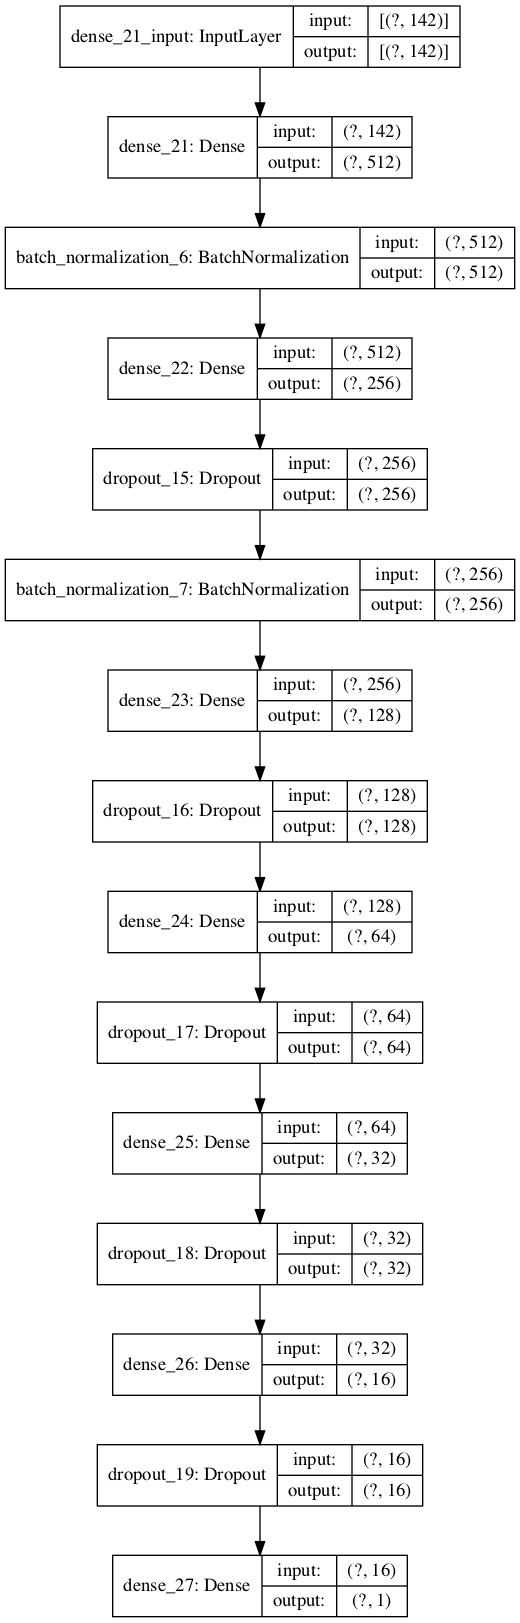

In [62]:
plot_model(seq_model, 'Images/Sequential Regression Model.png', show_shapes=True)

In [63]:
es = EarlyStopping(monitor='val_loss', patience=5)

In [64]:
history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, batch_size=32)

Epoch 1/400
1393/1393 [==============================] - 4s 3ms/step - loss: 12450967552.0000 - mse: 12450967552.0000 - rmse: 111583.9062 - mae: 47885.2070 - msle: 2.6006 - mape: 109.4476 - val_loss: 6994382336.0000 - val_mse: 6994382336.0000 - val_rmse: 83632.4219 - val_mae: 36087.1719 - val_msle: 0.6386 - val_mape: 78.9485
Epoch 2/400
1393/1393 [==============================] - 4s 3ms/step - loss: 11865596928.0000 - mse: 11865596928.0000 - rmse: 108929.3203 - mae: 46163.0703 - msle: 1.3524 - mape: 105.8931 - val_loss: 8413717504.0000 - val_mse: 8413717504.0000 - val_rmse: 91726.3203 - val_mae: 37096.7891 - val_msle: 0.6363 - val_mape: 66.3606
Epoch 3/400
1393/1393 [==============================] - 4s 3ms/step - loss: 10956947456.0000 - mse: 10956947456.0000 - rmse: 104675.4375 - mae: 44880.7578 - msle: 1.2432 - mape: 103.3977 - val_loss: 9822683136.0000 - val_mse: 9822683136.0000 - val_rmse: 99109.4531 - val_mae: 39335.6836 - val_msle: 0.6261 - val_mape: 87.8152
Epoch 4/400
1393/13

1393/1393 [==============================] - 4s 3ms/step - loss: 9561025536.0000 - mse: 9561025536.0000 - rmse: 97780.5000 - mae: 42458.9648 - msle: 0.9604 - mape: 95.9684 - val_loss: 9572204544.0000 - val_mse: 9572204544.0000 - val_rmse: 97837.6406 - val_mae: 40166.6133 - val_msle: 0.9864 - val_mape: 53.0780
Epoch 27/400
1393/1393 [==============================] - 4s 3ms/step - loss: 9486937088.0000 - mse: 9486937088.0000 - rmse: 97400.9062 - mae: 42348.7031 - msle: 0.9585 - mape: 100.6662 - val_loss: 7368910848.0000 - val_mse: 7368910848.0000 - val_rmse: 85842.3594 - val_mae: 36574.4492 - val_msle: 0.8639 - val_mape: 53.5635
Epoch 28/400
1393/1393 [==============================] - 4s 3ms/step - loss: 9327403008.0000 - mse: 9327403008.0000 - rmse: 96578.4844 - mae: 41998.8359 - msle: 0.9588 - mape: 97.9469 - val_loss: 9494516736.0000 - val_mse: 9494516736.0000 - val_rmse: 97439.8125 - val_mae: 40743.4023 - val_msle: 1.0935 - val_mape: 52.5221
Epoch 29/400
1393/1393 [================

1393/1393 [==============================] - 4s 3ms/step - loss: 8836625408.0000 - mse: 8836625408.0000 - rmse: 94003.3281 - mae: 41511.1875 - msle: 0.9302 - mape: 98.1943 - val_loss: 8333770752.0000 - val_mse: 8333770752.0000 - val_rmse: 91289.4922 - val_mae: 37250.5898 - val_msle: 0.7187 - val_mape: 55.1153
Epoch 52/400
1393/1393 [==============================] - 5s 4ms/step - loss: 9263640576.0000 - mse: 9263640576.0000 - rmse: 96247.8047 - mae: 41847.9414 - msle: 0.9500 - mape: 97.0996 - val_loss: 10241064960.0000 - val_mse: 10241064960.0000 - val_rmse: 101198.1484 - val_mae: 41094.5938 - val_msle: 0.9542 - val_mape: 50.7208
Epoch 53/400
1393/1393 [==============================] - 4s 3ms/step - loss: 8423947776.0000 - mse: 8423947776.0000 - rmse: 91782.0703 - mae: 40988.1758 - msle: 0.9262 - mape: 100.3335 - val_loss: 9100179456.0000 - val_mse: 9100179456.0000 - val_rmse: 95394.8594 - val_mae: 39166.0195 - val_msle: 0.8820 - val_mape: 52.0513
Epoch 54/400
1393/1393 [=============

1393/1393 [==============================] - 4s 3ms/step - loss: 7893245952.0000 - mse: 7893245952.0000 - rmse: 88843.9453 - mae: 39664.8633 - msle: 0.8479 - mape: 92.4648 - val_loss: 39591268352.0000 - val_mse: 39591268352.0000 - val_rmse: 198975.5469 - val_mae: 39015.9492 - val_msle: 0.6540 - val_mape: 82.6507
Epoch 77/400
1393/1393 [==============================] - 4s 3ms/step - loss: 8034969088.0000 - mse: 8034969088.0000 - rmse: 89637.9922 - mae: 39735.0547 - msle: 0.8466 - mape: 97.2753 - val_loss: 835574431744.0000 - val_mse: 835574431744.0000 - val_rmse: 914097.6250 - val_mae: 64005.4883 - val_msle: 0.7035 - val_mape: 212.0829
Epoch 78/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7904306176.0000 - mse: 7904306176.0000 - rmse: 88906.1641 - mae: 39383.1523 - msle: 0.8266 - mape: 91.5028 - val_loss: 21201799168.0000 - val_mse: 21201799168.0000 - val_rmse: 145608.3750 - val_mae: 38082.8164 - val_msle: 0.6548 - val_mape: 70.2714
Epoch 79/400
1393/1393 [=====

Epoch 101/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7792746496.0000 - mse: 7792746496.0000 - rmse: 88276.5312 - mae: 40056.7109 - msle: 0.8431 - mape: 105.9381 - val_loss: 617937043456.0000 - val_mse: 617937043456.0000 - val_rmse: 786089.6875 - val_mae: 49802.4688 - val_msle: 0.7211 - val_mape: 196.3221
Epoch 102/400
1393/1393 [==============================] - 4s 3ms/step - loss: 8079089152.0000 - mse: 8079089152.0000 - rmse: 89883.7500 - mae: 40132.7188 - msle: 0.8285 - mape: 103.3235 - val_loss: 306030936064.0000 - val_mse: 306030936064.0000 - val_rmse: 553200.6250 - val_mae: 53736.0703 - val_msle: 0.7616 - val_mape: 179.1691
Epoch 103/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7965280256.0000 - mse: 7965280256.0000 - rmse: 89248.4219 - mae: 40118.6484 - msle: 0.8377 - mape: 108.2737 - val_loss: 658908381184.0000 - val_mse: 658908381184.0000 - val_rmse: 811731.6875 - val_mae: 59906.6016 - val_msle: 0.7762 - val_mape: 176.3178
Epoc

1393/1393 [==============================] - 4s 3ms/step - loss: 7522891776.0000 - mse: 7522891776.0000 - rmse: 86734.6016 - mae: 40044.1250 - msle: 0.8536 - mape: 110.9635 - val_loss: 55261220864.0000 - val_mse: 55261220864.0000 - val_rmse: 235077.0469 - val_mae: 43496.3047 - val_msle: 0.7972 - val_mape: 123.8343
Epoch 126/400
1393/1393 [==============================] - 4s 3ms/step - loss: 8056337920.0000 - mse: 8056337920.0000 - rmse: 89757.1016 - mae: 40073.4609 - msle: 0.8403 - mape: 107.3756 - val_loss: 109687709696.0000 - val_mse: 109687709696.0000 - val_rmse: 331191.3438 - val_mae: 45990.6016 - val_msle: 0.7381 - val_mape: 119.3282
Epoch 127/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7650218496.0000 - mse: 7650218496.0000 - rmse: 87465.5312 - mae: 39752.7539 - msle: 0.8425 - mape: 107.7860 - val_loss: 104823037952.0000 - val_mse: 104823037952.0000 - val_rmse: 323763.8750 - val_mae: 47638.1094 - val_msle: 0.7327 - val_mape: 126.1271
Epoch 128/400
1393/1

1393/1393 [==============================] - 4s 3ms/step - loss: 7443147776.0000 - mse: 7443147776.0000 - rmse: 86273.6797 - mae: 39499.7031 - msle: 0.8342 - mape: 106.6731 - val_loss: 7772709888.0000 - val_mse: 7772709888.0000 - val_rmse: 88162.9766 - val_mae: 37798.6328 - val_msle: 0.7340 - val_mape: 103.2986
Epoch 151/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7791207424.0000 - mse: 7791207424.0000 - rmse: 88267.8203 - mae: 40118.3477 - msle: 0.8558 - mape: 111.0271 - val_loss: 9146606592.0000 - val_mse: 9146606592.0000 - val_rmse: 95637.8906 - val_mae: 38935.5938 - val_msle: 0.7271 - val_mape: 96.5867
Epoch 152/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7772014080.0000 - mse: 7772014080.0000 - rmse: 88159.0234 - mae: 40274.4883 - msle: 0.8576 - mape: 110.6028 - val_loss: 8219236864.0000 - val_mse: 8219236864.0000 - val_rmse: 90660.0078 - val_mae: 38529.8438 - val_msle: 0.7556 - val_mape: 105.6656
Epoch 153/400
1393/1393 [=========

1393/1393 [==============================] - 4s 3ms/step - loss: 7395772928.0000 - mse: 7395772928.0000 - rmse: 85998.6797 - mae: 39841.3789 - msle: 0.8448 - mape: 112.5858 - val_loss: 8130846208.0000 - val_mse: 8130846208.0000 - val_rmse: 90171.2031 - val_mae: 37370.8477 - val_msle: 0.7057 - val_mape: 94.0620
Epoch 176/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7527946752.0000 - mse: 7527946752.0000 - rmse: 86763.7422 - mae: 39560.8594 - msle: 0.8380 - mape: 109.9047 - val_loss: 8475088384.0000 - val_mse: 8475088384.0000 - val_rmse: 92060.2422 - val_mae: 37595.1016 - val_msle: 0.6921 - val_mape: 92.3622
Epoch 177/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7225633280.0000 - mse: 7225633280.0000 - rmse: 85003.7266 - mae: 39439.1719 - msle: 0.8413 - mape: 108.4860 - val_loss: 8720118784.0000 - val_mse: 8720118784.0000 - val_rmse: 93381.5781 - val_mae: 37575.2266 - val_msle: 0.6891 - val_mape: 86.2054
Epoch 178/400
1393/1393 [===========

1393/1393 [==============================] - 4s 3ms/step - loss: 7909527040.0000 - mse: 7909527040.0000 - rmse: 88935.5234 - mae: 40201.6758 - msle: 0.8541 - mape: 107.8924 - val_loss: 9000276992.0000 - val_mse: 9000276992.0000 - val_rmse: 94869.7891 - val_mae: 38896.3281 - val_msle: 0.7316 - val_mape: 101.8993
Epoch 201/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7738438656.0000 - mse: 7738438656.0000 - rmse: 87968.3984 - mae: 40320.9102 - msle: 0.8504 - mape: 112.6880 - val_loss: 9780171776.0000 - val_mse: 9780171776.0000 - val_rmse: 98894.7500 - val_mae: 39137.8047 - val_msle: 0.7145 - val_mape: 91.8015
Epoch 202/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7263361024.0000 - mse: 7263361024.0000 - rmse: 85225.3516 - mae: 39877.6953 - msle: 0.8653 - mape: 115.9136 - val_loss: 7572492800.0000 - val_mse: 7572492800.0000 - val_rmse: 87020.0703 - val_mae: 38184.2773 - val_msle: 0.7785 - val_mape: 112.0589
Epoch 203/400
1393/1393 [=========

1393/1393 [==============================] - 4s 3ms/step - loss: 7344724480.0000 - mse: 7344724480.0000 - rmse: 85701.3672 - mae: 39887.9023 - msle: 0.8665 - mape: 115.3570 - val_loss: 8245272576.0000 - val_mse: 8245272576.0000 - val_rmse: 90803.4844 - val_mae: 37655.8516 - val_msle: 0.7220 - val_mape: 100.5670
Epoch 226/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7562159616.0000 - mse: 7562159616.0000 - rmse: 86960.6797 - mae: 40218.8906 - msle: 0.8647 - mape: 117.0869 - val_loss: 8481784832.0000 - val_mse: 8481784832.0000 - val_rmse: 92096.6094 - val_mae: 38103.4219 - val_msle: 0.7377 - val_mape: 101.7961
Epoch 227/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7515136512.0000 - mse: 7515136512.0000 - rmse: 86689.8906 - mae: 40003.5508 - msle: 0.8598 - mape: 115.2864 - val_loss: 7317003264.0000 - val_mse: 7317003264.0000 - val_rmse: 85539.4844 - val_mae: 38693.2461 - val_msle: 0.8268 - val_mape: 123.4382
Epoch 228/400
1393/1393 [========

1393/1393 [==============================] - 4s 3ms/step - loss: 7026493440.0000 - mse: 7026493440.0000 - rmse: 83824.1797 - mae: 39304.2305 - msle: 0.8462 - mape: 114.2448 - val_loss: 8992590848.0000 - val_mse: 8992590848.0000 - val_rmse: 94829.2734 - val_mae: 38356.6445 - val_msle: 0.7309 - val_mape: 99.2826
Epoch 251/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7128192000.0000 - mse: 7128192000.0000 - rmse: 84428.6172 - mae: 39551.7969 - msle: 0.8601 - mape: 117.8731 - val_loss: 8276378624.0000 - val_mse: 8276378624.0000 - val_rmse: 90974.6016 - val_mae: 38403.1445 - val_msle: 0.7621 - val_mape: 105.4168
Epoch 252/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7103318016.0000 - mse: 7103318016.0000 - rmse: 84281.1875 - mae: 39618.2734 - msle: 0.8577 - mape: 116.6267 - val_loss: 8106540032.0000 - val_mse: 8106540032.0000 - val_rmse: 90036.3281 - val_mae: 37605.0586 - val_msle: 0.7247 - val_mape: 99.7294
Epoch 253/400
1393/1393 [==========

1393/1393 [==============================] - 4s 3ms/step - loss: 7336880128.0000 - mse: 7336880128.0000 - rmse: 85655.5938 - mae: 39713.7891 - msle: 0.8482 - mape: 115.3402 - val_loss: 8790757376.0000 - val_mse: 8790757376.0000 - val_rmse: 93759.0391 - val_mae: 38062.1992 - val_msle: 0.7169 - val_mape: 91.4241
Epoch 276/400
1393/1393 [==============================] - 4s 3ms/step - loss: 6943856128.0000 - mse: 6943856128.0000 - rmse: 83329.8047 - mae: 39275.0664 - msle: 0.8564 - mape: 115.2178 - val_loss: 8203437568.0000 - val_mse: 8203437568.0000 - val_rmse: 90572.8281 - val_mae: 37103.4102 - val_msle: 0.6842 - val_mape: 88.9464
Epoch 277/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7212492800.0000 - mse: 7212492800.0000 - rmse: 84926.3984 - mae: 39540.7930 - msle: 0.8460 - mape: 114.6175 - val_loss: 8357582848.0000 - val_mse: 8357582848.0000 - val_rmse: 91419.8203 - val_mae: 37866.0625 - val_msle: 0.7293 - val_mape: 101.0888
Epoch 278/400
1393/1393 [==========

1393/1393 [==============================] - 4s 3ms/step - loss: 6904599040.0000 - mse: 6904599040.0000 - rmse: 83093.9141 - mae: 38960.0938 - msle: 0.8367 - mape: 113.1144 - val_loss: 8968000512.0000 - val_mse: 8968000512.0000 - val_rmse: 94699.5312 - val_mae: 38195.7500 - val_msle: 0.7192 - val_mape: 94.5680
Epoch 301/400
1393/1393 [==============================] - 4s 3ms/step - loss: 6970543616.0000 - mse: 6970543616.0000 - rmse: 83489.7812 - mae: 39195.4375 - msle: 0.8419 - mape: 114.6751 - val_loss: 9519172608.0000 - val_mse: 9519172608.0000 - val_rmse: 97566.2500 - val_mae: 38335.6133 - val_msle: 0.6936 - val_mape: 89.2987
Epoch 302/400
1393/1393 [==============================] - 4s 3ms/step - loss: 6928300032.0000 - mse: 6928300032.0000 - rmse: 83236.4141 - mae: 39012.5430 - msle: 0.8385 - mape: 111.0628 - val_loss: 7605451776.0000 - val_mse: 7605451776.0000 - val_rmse: 87209.2422 - val_mae: 37642.9766 - val_msle: 0.7426 - val_mape: 106.9976
Epoch 303/400
1393/1393 [==========

1393/1393 [==============================] - 4s 3ms/step - loss: 6991173632.0000 - mse: 6991173632.0000 - rmse: 83613.2422 - mae: 39313.3867 - msle: 0.8472 - mape: 112.7796 - val_loss: 7859438592.0000 - val_mse: 7859438592.0000 - val_rmse: 88653.4766 - val_mae: 38440.0547 - val_msle: 0.7819 - val_mape: 114.8969
Epoch 326/400
1393/1393 [==============================] - 4s 3ms/step - loss: 6909115904.0000 - mse: 6909115904.0000 - rmse: 83121.0938 - mae: 39161.2109 - msle: 0.8471 - mape: 116.2648 - val_loss: 7982346240.0000 - val_mse: 7982346240.0000 - val_rmse: 89343.9766 - val_mae: 38463.6406 - val_msle: 0.7806 - val_mape: 111.8978
Epoch 327/400
1393/1393 [==============================] - 4s 3ms/step - loss: 6909965824.0000 - mse: 6909965824.0000 - rmse: 83126.2031 - mae: 39427.2734 - msle: 0.8591 - mape: 117.0391 - val_loss: 8781218816.0000 - val_mse: 8781218816.0000 - val_rmse: 93708.1562 - val_mae: 38169.6719 - val_msle: 0.7304 - val_mape: 97.3746
Epoch 328/400
1393/1393 [=========

1393/1393 [==============================] - 4s 3ms/step - loss: 6869009408.0000 - mse: 6869009408.0000 - rmse: 82879.4844 - mae: 39061.8633 - msle: 0.8432 - mape: 118.0864 - val_loss: 8030831104.0000 - val_mse: 8030831104.0000 - val_rmse: 89614.9062 - val_mae: 38010.3867 - val_msle: 0.7529 - val_mape: 106.0122
Epoch 351/400
1393/1393 [==============================] - 4s 3ms/step - loss: 6726223360.0000 - mse: 6726223360.0000 - rmse: 82013.5547 - mae: 38938.2383 - msle: 0.8413 - mape: 114.3493 - val_loss: 8111168000.0000 - val_mse: 8111168000.0000 - val_rmse: 90062.0234 - val_mae: 38064.2344 - val_msle: 0.7559 - val_mape: 105.7146
Epoch 352/400
1393/1393 [==============================] - 4s 3ms/step - loss: 6806257152.0000 - mse: 6806257152.0000 - rmse: 82500.0469 - mae: 38700.0820 - msle: 0.8371 - mape: 113.3111 - val_loss: 8167297536.0000 - val_mse: 8167297536.0000 - val_rmse: 90373.1016 - val_mae: 38307.3711 - val_msle: 0.7623 - val_mape: 106.0519
Epoch 353/400
1393/1393 [========

1393/1393 [==============================] - 4s 3ms/step - loss: 7142979584.0000 - mse: 7142979584.0000 - rmse: 84516.1484 - mae: 39319.3164 - msle: 0.8454 - mape: 116.6520 - val_loss: 8071547904.0000 - val_mse: 8071547904.0000 - val_rmse: 89841.7969 - val_mae: 38853.9297 - val_msle: 0.8065 - val_mape: 121.0518
Epoch 376/400
1393/1393 [==============================] - 4s 3ms/step - loss: 6929080832.0000 - mse: 6929080832.0000 - rmse: 83241.1016 - mae: 39192.2422 - msle: 0.8443 - mape: 115.5832 - val_loss: 8506449920.0000 - val_mse: 8506449920.0000 - val_rmse: 92230.4141 - val_mae: 38932.1484 - val_msle: 0.7813 - val_mape: 112.6399
Epoch 377/400
1393/1393 [==============================] - 4s 3ms/step - loss: 7453834240.0000 - mse: 7453834240.0000 - rmse: 86335.5938 - mae: 39558.5859 - msle: 0.8564 - mape: 114.9920 - val_loss: 9969179648.0000 - val_mse: 9969179648.0000 - val_rmse: 99845.7812 - val_mae: 39356.4141 - val_msle: 0.7388 - val_mape: 93.0441
Epoch 378/400
1393/1393 [=========

1393/1393 [==============================] - 4s 3ms/step - loss: 6878680576.0000 - mse: 6878680576.0000 - rmse: 82937.8125 - mae: 39193.0703 - msle: 0.8491 - mape: 116.3038 - val_loss: 7597687808.0000 - val_mse: 7597687808.0000 - val_rmse: 87164.7188 - val_mae: 38211.8867 - val_msle: 0.7829 - val_mape: 114.7077


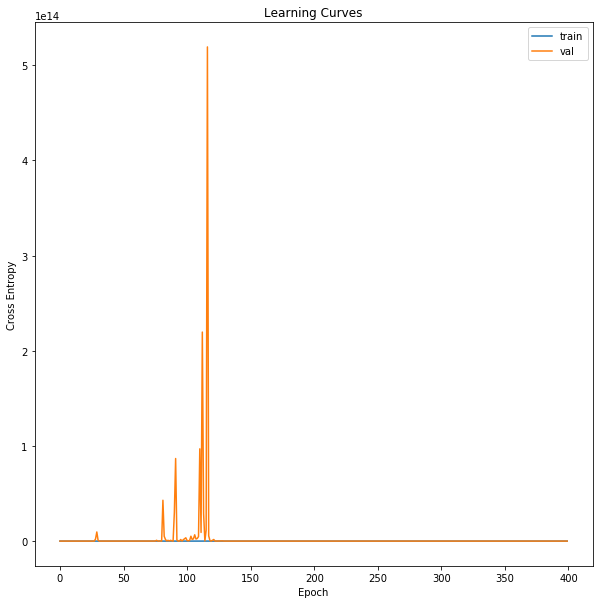

In [99]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

In [66]:
error = seq_model.evaluate(X_test, y_test)

597/597 [==============================] - 1s 963us/step - loss: 7597687808.0000 - mse: 7597687808.0000 - rmse: 87164.7188 - mae: 38211.8867 - msle: 0.7829 - mape: 114.7077


In [67]:
print('MSE: %.3f, RMSE: %.3f, MSLE: %.3f, MAE: %.3f, MAPE: %.3f' % 
      (error[1], error[2], error[4], error[3], error[5]))

MSE: 7597687808.000, RMSE: 87164.719, MSLE: 0.783, MAE: 38211.887, MAPE: 114.708


Text(0, 0.5, 'predicted values (test data)')

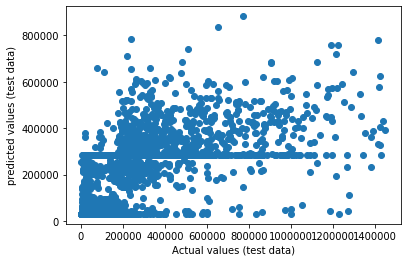

In [68]:
predictions= seq_model.predict(X_test)
plt.plot(y_test, predictions, 'o')
plt.xlabel('Actual values (test data)')
plt.ylabel('predicted values (test data)')

In [93]:
r2_seq = r2_score(y_test, predictions)
r2_seq

0.5900562399770255

Text(0, 0.5, 'predicted values (train data)')

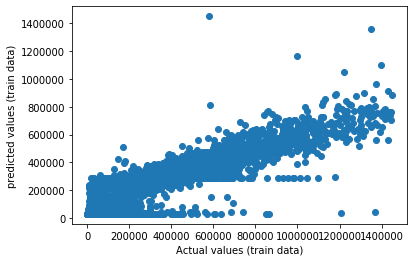

In [70]:
train_predictions = seq_model.predict(X_train)
plt.plot(y_train, train_predictions, 'o')
plt.xlabel('Actual values (train data)')
plt.ylabel('predicted values (train data)')

In [71]:
predictions = predictions.flatten()

In [72]:
train_predictions = train_predictions.flatten()

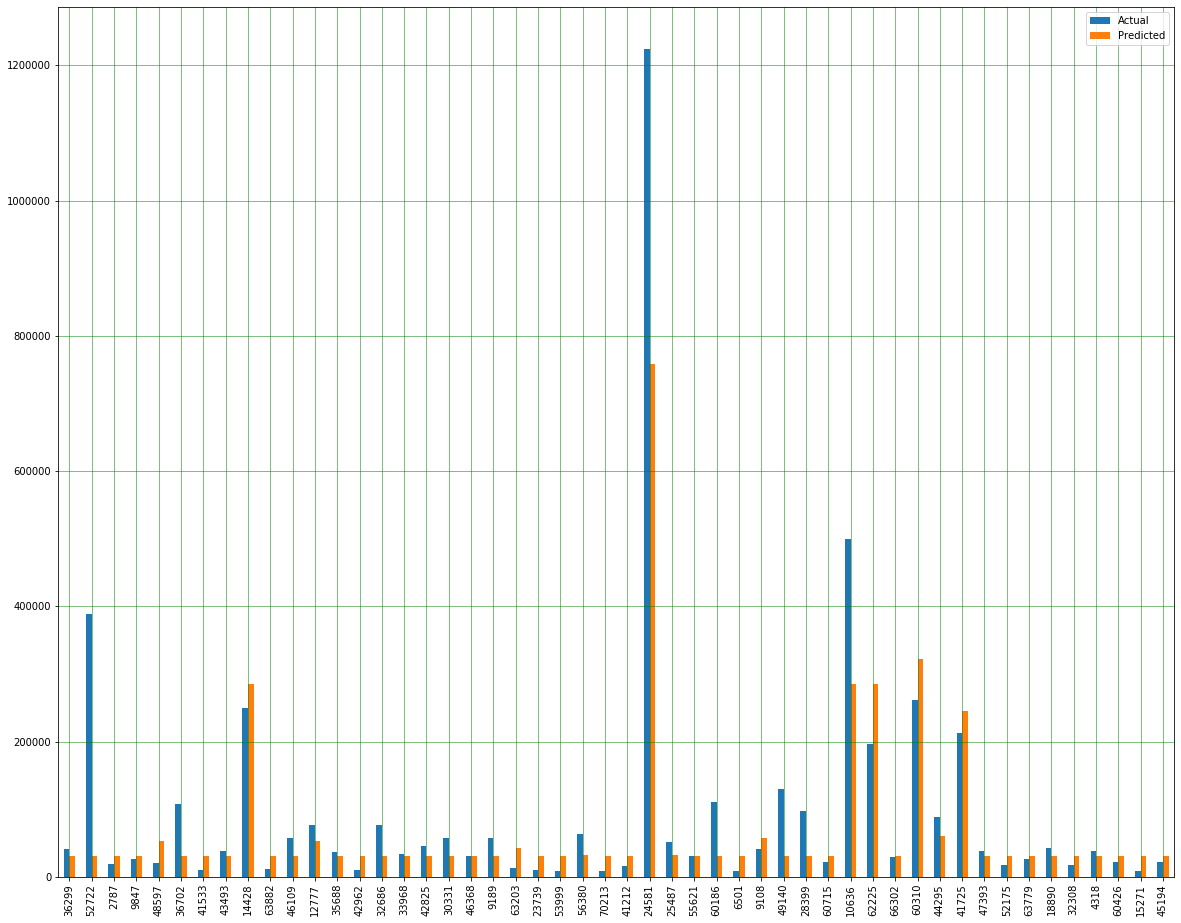

In [73]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

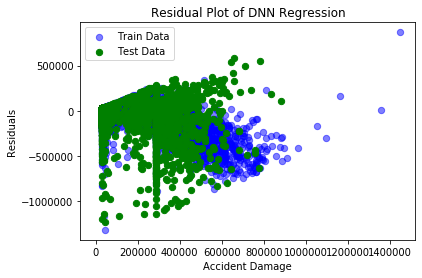

In [74]:
plt.scatter(train_predictions, train_predictions - y_train, c='b', s=40, alpha=0.5, label='Train Data')
plt.scatter(predictions, predictions - y_test, c='g', s=40, label='Test Data')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residual Plot of DNN Regression')
plt.ylabel('Residuals')
plt.xlabel('Accident Damage')
plt.legend()
plt.show()

## Functional API Regression Model with Keras

In [75]:
x_in = Input(shape=(n_features,))
dense = Dense(1024, activation=activation)
x = dense(x_in)
x = Dense(512, activation=activation)(x)
x = Dense(256, activation=activation)(x)
x = Dense(128, activation=activation)(x)
x = Dense(16, activation=activation)(x)
x_out = Dense(1)(x)
func_model = Model(inputs=x_in, outputs=x_out)

In [76]:
func_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 142)]             0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              146432    
_________________________________________________________________
dense_29 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_32 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17    

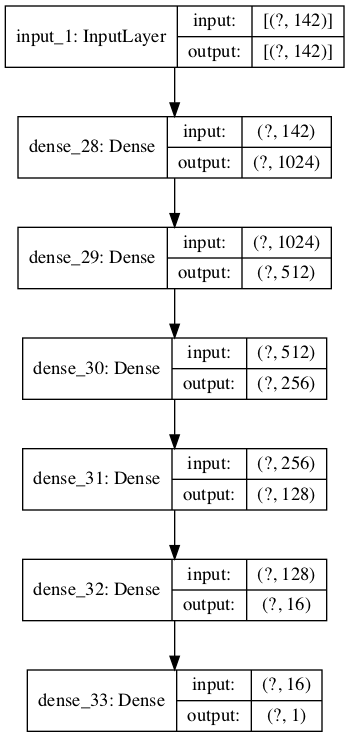

In [77]:
plot_model(func_model, 'Images/Functional API Regression Model.png', show_shapes=True)

In [78]:
func_model.compile(optimizer=opt, loss='mse', metrics=metrics)

In [79]:
es = EarlyStopping(monitor='val_loss', patience=5)

In [80]:
func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, batch_size=32)

Epoch 1/400
1393/1393 [==============================] - 7s 5ms/step - loss: 7940879872.0000 - mse: 7940879872.0000 - rmse: 88532.0000 - mae: 40196.7734 - msle: 1.1296 - mape: 114.7102 - val_loss: 6479202816.0000 - val_mse: 6479202816.0000 - val_rmse: 80493.4922 - val_mae: 36225.1875 - val_msle: 0.6637 - val_mape: 100.7729
Epoch 2/400
1393/1393 [==============================] - 7s 5ms/step - loss: 6369249280.0000 - mse: 6369249280.0000 - rmse: 79807.5781 - mae: 36895.6914 - msle: 0.6924 - mape: 108.8825 - val_loss: 6318091776.0000 - val_mse: 6318091776.0000 - val_rmse: 79486.4219 - val_mae: 34816.7500 - val_msle: 0.6193 - val_mape: 84.68290.6910 - ma
Epoch 3/400
1393/1393 [==============================] - 7s 5ms/step - loss: 6105671680.0000 - mse: 6105671680.0000 - rmse: 78138.7969 - mae: 36019.2109 - msle: 0.6617 - mape: 106.8848 - val_loss: 6292871168.0000 - val_mse: 6292871168.0000 - val_rmse: 79327.6172 - val_mae: 36384.1992 - val_msle: 0.6667 - val_mape: 103.9884
Epoch 4/400
139

1393/1393 [==============================] - 9s 6ms/step - loss: 1455227136.0000 - mse: 1455227136.0000 - rmse: 38147.4375 - mae: 22265.2715 - msle: 0.4786 - mape: 80.9165 - val_loss: 8738566144.0000 - val_mse: 8738566144.0000 - val_rmse: 93480.2969 - val_mae: 42076.8281 - val_msle: 0.7613 - val_mape: 116.6145
Epoch 27/400
1393/1393 [==============================] - 8s 6ms/step - loss: 1438706176.0000 - mse: 1438706176.0000 - rmse: 37930.2812 - mae: 21953.8730 - msle: 0.4714 - mape: 79.3831 - val_loss: 8120071680.0000 - val_mse: 8120071680.0000 - val_rmse: 90111.4375 - val_mae: 39802.0938 - val_msle: 0.7185 - val_mape: 104.4748
Epoch 28/400
1393/1393 [==============================] - 8s 5ms/step - loss: 1365568640.0000 - mse: 1365568640.0000 - rmse: 36953.6016 - mae: 21499.1660 - msle: 0.4625 - mape: 78.4380 - val_loss: 8073113088.0000 - val_mse: 8073113088.0000 - val_rmse: 89850.5078 - val_mae: 39907.5977 - val_msle: 0.7421 - val_mape: 110.4421
Epoch 29/400
1393/1393 [==============

1393/1393 [==============================] - 7s 5ms/step - loss: 650003328.0000 - mse: 650003328.0000 - rmse: 25495.1621 - mae: 15195.6904 - msle: 0.3264 - mape: 58.4828 - val_loss: 8095378432.0000 - val_mse: 8095378432.0000 - val_rmse: 89974.3203 - val_mae: 40688.4961 - val_msle: 0.7847 - val_mape: 108.1269
Epoch 52/400
1393/1393 [==============================] - 8s 6ms/step - loss: 692443712.0000 - mse: 692443712.0000 - rmse: 26314.3262 - mae: 15345.3086 - msle: 0.3256 - mape: 58.3121 - val_loss: 8125693952.0000 - val_mse: 8125693952.0000 - val_rmse: 90142.6328 - val_mae: 41442.0312 - val_msle: 0.8079 - val_mape: 114.2473
Epoch 53/400
1393/1393 [==============================] - 8s 5ms/step - loss: 678423104.0000 - mse: 678423104.0000 - rmse: 26046.5566 - mae: 15239.2432 - msle: 0.3285 - mape: 58.1821 - val_loss: 7993253376.0000 - val_mse: 7993253376.0000 - val_rmse: 89405.0000 - val_mae: 39634.1172 - val_msle: 0.7838 - val_mape: 100.2296
Epoch 54/400
1393/1393 [====================

1393/1393 [==============================] - 8s 6ms/step - loss: 421231424.0000 - mse: 421231424.0000 - rmse: 20523.9238 - mae: 12034.6191 - msle: 0.2461 - mape: 46.7020 - val_loss: 8507502592.0000 - val_mse: 8507502592.0000 - val_rmse: 92236.1250 - val_mae: 42292.3945 - val_msle: 0.8613 - val_mape: 114.2506
Epoch 77/400
1393/1393 [==============================] - 8s 6ms/step - loss: 446239296.0000 - mse: 446239296.0000 - rmse: 21124.3770 - mae: 12177.2803 - msle: 0.2463 - mape: 47.0073 - val_loss: 8299304448.0000 - val_mse: 8299304448.0000 - val_rmse: 91100.5156 - val_mae: 41772.3984 - val_msle: 0.8415 - val_mape: 112.2913
Epoch 78/400
1393/1393 [==============================] - 8s 6ms/step - loss: 400759776.0000 - mse: 400759776.0000 - rmse: 20018.9863 - mae: 11903.1738 - msle: 0.2439 - mape: 45.9604 - val_loss: 8234124800.0000 - val_mse: 8234124800.0000 - val_rmse: 90742.0781 - val_mae: 41016.3008 - val_msle: 0.8325 - val_mape: 108.2690
Epoch 79/400
1393/1393 [====================

1393/1393 [==============================] - 7s 5ms/step - loss: 343191904.0000 - mse: 343191904.0000 - rmse: 18525.4395 - mae: 10631.1953 - msle: 0.2064 - mape: 40.8753 - val_loss: 8432846336.0000 - val_mse: 8432846336.0000 - val_rmse: 91830.5312 - val_mae: 42394.0234 - val_msle: 0.8665 - val_mape: 117.3347
Epoch 102/400
1393/1393 [==============================] - 8s 5ms/step - loss: 321004960.0000 - mse: 321004960.0000 - rmse: 17916.6113 - mae: 10302.7402 - msle: 0.1955 - mape: 39.9789 - val_loss: 7982311936.0000 - val_mse: 7982311936.0000 - val_rmse: 89343.7812 - val_mae: 40800.0430 - val_msle: 0.8486 - val_mape: 107.5194
Epoch 103/400
1393/1393 [==============================] - 7s 5ms/step - loss: 308130208.0000 - mse: 308130208.0000 - rmse: 17553.6387 - mae: 10106.4883 - msle: 0.1939 - mape: 39.6696 - val_loss: 8035798016.0000 - val_mse: 8035798016.0000 - val_rmse: 89642.6094 - val_mae: 40999.0977 - val_msle: 0.8472 - val_mape: 107.3980
Epoch 104/400
1393/1393 [=================

1393/1393 [==============================] - 7s 5ms/step - loss: 233217568.0000 - mse: 233217568.0000 - rmse: 15271.4629 - mae: 8898.2129 - msle: 0.1664 - mape: 35.5711 - val_loss: 7970147328.0000 - val_mse: 7970147328.0000 - val_rmse: 89275.6797 - val_mae: 40408.6328 - val_msle: 0.8702 - val_mape: 104.6914
Epoch 127/400
1393/1393 [==============================] - 7s 5ms/step - loss: 275346624.0000 - mse: 275346624.0000 - rmse: 16593.5723 - mae: 9346.4170 - msle: 0.1689 - mape: 36.7493 - val_loss: 7855569920.0000 - val_mse: 7855569920.0000 - val_rmse: 88631.6562 - val_mae: 40857.0898 - val_msle: 0.8981 - val_mape: 110.5942
Epoch 128/400
1393/1393 [==============================] - 7s 5ms/step - loss: 275565984.0000 - mse: 275565984.0000 - rmse: 16600.1797 - mae: 9393.6611 - msle: 0.1704 - mape: 36.3295 - val_loss: 8181174272.0000 - val_mse: 8181174272.0000 - val_rmse: 90449.8438 - val_mae: 42300.4375 - val_msle: 0.8896 - val_mape: 120.2352
Epoch 129/400
1393/1393 [====================

1393/1393 [==============================] - 7s 5ms/step - loss: 203672272.0000 - mse: 203672272.0000 - rmse: 14271.3799 - mae: 8192.0811 - msle: 0.1452 - mape: 31.8299 - val_loss: 8033629184.0000 - val_mse: 8033629184.0000 - val_rmse: 89630.5156 - val_mae: 40878.1367 - val_msle: 0.8794 - val_mape: 106.5303
Epoch 152/400
1393/1393 [==============================] - 7s 5ms/step - loss: 227097056.0000 - mse: 227097056.0000 - rmse: 15069.7393 - mae: 8457.7646 - msle: 0.1541 - mape: 33.0859 - val_loss: 8115939840.0000 - val_mse: 8115939840.0000 - val_rmse: 90088.5078 - val_mae: 41740.6992 - val_msle: 0.8914 - val_mape: 114.3646
Epoch 153/400
1393/1393 [==============================] - 7s 5ms/step - loss: 197362288.0000 - mse: 197362288.0000 - rmse: 14048.5693 - mae: 8117.0454 - msle: 0.1455 - mape: 32.0036 - val_loss: 7878837248.0000 - val_mse: 7878837248.0000 - val_rmse: 88762.8125 - val_mae: 40162.6367 - val_msle: 0.9157 - val_mape: 103.0192
Epoch 154/400
1393/1393 [====================

1393/1393 [==============================] - 8s 6ms/step - loss: 176294848.0000 - mse: 176294848.0000 - rmse: 13277.6074 - mae: 7372.0073 - msle: 0.1276 - mape: 29.8488 - val_loss: 8210805248.0000 - val_mse: 8210805248.0000 - val_rmse: 90613.4922 - val_mae: 42324.1758 - val_msle: 0.9081 - val_mape: 120.0178
Epoch 177/400
1393/1393 [==============================] - 8s 6ms/step - loss: 153866944.0000 - mse: 153866944.0000 - rmse: 12404.3115 - mae: 7237.4937 - msle: 0.1239 - mape: 29.2370 - val_loss: 7918148608.0000 - val_mse: 7918148608.0000 - val_rmse: 88983.9766 - val_mae: 40832.1289 - val_msle: 0.9033 - val_mape: 107.5676
Epoch 178/400
1393/1393 [==============================] - 8s 6ms/step - loss: 182948560.0000 - mse: 182948560.0000 - rmse: 13525.8477 - mae: 7496.4150 - msle: 0.1295 - mape: 29.5865 - val_loss: 8025307136.0000 - val_mse: 8025307136.0000 - val_rmse: 89584.0781 - val_mae: 41361.2695 - val_msle: 0.8893 - val_mape: 113.5989
Epoch 179/400
1393/1393 [====================

1393/1393 [==============================] - 8s 6ms/step - loss: 128739016.0000 - mse: 128739016.0000 - rmse: 11346.3213 - mae: 6660.6069 - msle: 0.1137 - mape: 27.3905 - val_loss: 8083836928.0000 - val_mse: 8083836928.0000 - val_rmse: 89910.1641 - val_mae: 42131.9648 - val_msle: 0.9097 - val_mape: 118.7128
Epoch 202/400
1393/1393 [==============================] - 9s 6ms/step - loss: 145563344.0000 - mse: 145563344.0000 - rmse: 12064.9639 - mae: 6921.3164 - msle: 0.1119 - mape: 27.0954 - val_loss: 8148238336.0000 - val_mse: 8148238336.0000 - val_rmse: 90267.5938 - val_mae: 41867.6641 - val_msle: 0.9014 - val_mape: 115.5430
Epoch 203/400
1393/1393 [==============================] - 9s 6ms/step - loss: 152372896.0000 - mse: 152372896.0000 - rmse: 12343.9414 - mae: 7116.2949 - msle: 0.1173 - mape: 27.7374 - val_loss: 8120450048.0000 - val_mse: 8120450048.0000 - val_rmse: 90113.5391 - val_mae: 41960.2422 - val_msle: 0.8940 - val_mape: 116.2444
Epoch 204/400
1393/1393 [====================

1393/1393 [==============================] - 7s 5ms/step - loss: 129706600.0000 - mse: 129706600.0000 - rmse: 11388.8809 - mae: 6478.1890 - msle: 0.1021 - mape: 25.7078 - val_loss: 8149214208.0000 - val_mse: 8149214208.0000 - val_rmse: 90273.0000 - val_mae: 42104.2773 - val_msle: 0.8986 - val_mape: 118.4697
Epoch 227/400
1393/1393 [==============================] - 7s 5ms/step - loss: 129453720.0000 - mse: 129453720.0000 - rmse: 11377.7734 - mae: 6605.1699 - msle: 0.1124 - mape: 26.0122 - val_loss: 7890326016.0000 - val_mse: 7890326016.0000 - val_rmse: 88827.5078 - val_mae: 41089.7812 - val_msle: 0.9201 - val_mape: 111.2318
Epoch 228/400
1393/1393 [==============================] - 7s 5ms/step - loss: 140523424.0000 - mse: 140523424.0000 - rmse: 11854.2578 - mae: 6718.8394 - msle: 0.1067 - mape: 26.4824 - val_loss: 7999587840.0000 - val_mse: 7999587840.0000 - val_rmse: 89440.4141 - val_mae: 41493.6406 - val_msle: 0.9028 - val_mape: 115.0037
Epoch 229/400
1393/1393 [====================

1393/1393 [==============================] - 7s 5ms/step - loss: 139660272.0000 - mse: 139660272.0000 - rmse: 11817.7949 - mae: 6632.3828 - msle: 0.1097 - mape: 25.4982 - val_loss: 8219004416.0000 - val_mse: 8219004416.0000 - val_rmse: 90658.7266 - val_mae: 42553.6445 - val_msle: 0.9249 - val_mape: 120.7924
Epoch 252/400
1393/1393 [==============================] - 7s 5ms/step - loss: 122253552.0000 - mse: 122253552.0000 - rmse: 11056.8330 - mae: 6384.8701 - msle: 0.1061 - mape: 25.2017 - val_loss: 7943096320.0000 - val_mse: 7943096320.0000 - val_rmse: 89124.0469 - val_mae: 41588.7266 - val_msle: 0.9254 - val_mape: 116.6153
Epoch 253/400
1393/1393 [==============================] - 7s 5ms/step - loss: 132371880.0000 - mse: 132371880.0000 - rmse: 11505.2979 - mae: 6481.7949 - msle: 0.1010 - mape: 25.6759 - val_loss: 7980798976.0000 - val_mse: 7980798976.0000 - val_rmse: 89335.3203 - val_mae: 42091.6094 - val_msle: 0.9284 - val_mape: 119.9240
Epoch 254/400
1393/1393 [====================

1393/1393 [==============================] - 7s 5ms/step - loss: 95229528.0000 - mse: 95229528.0000 - rmse: 9758.5615 - mae: 5816.3735 - msle: 0.0903 - mape: 23.4285 - val_loss: 7907205120.0000 - val_mse: 7907205120.0000 - val_rmse: 88922.4688 - val_mae: 41358.2188 - val_msle: 0.9266 - val_mape: 112.7802
Epoch 277/400
1393/1393 [==============================] - 7s 5ms/step - loss: 95910392.0000 - mse: 95910392.0000 - rmse: 9793.3848 - mae: 5872.8799 - msle: 0.0902 - mape: 23.8397 - val_loss: 7987540480.0000 - val_mse: 7987540480.0000 - val_rmse: 89373.0391 - val_mae: 41630.1797 - val_msle: 0.9179 - val_mape: 115.9333
Epoch 278/400
1393/1393 [==============================] - 8s 5ms/step - loss: 105879440.0000 - mse: 105879440.0000 - rmse: 10289.7734 - mae: 6063.1851 - msle: 0.0944 - mape: 23.7751 - val_loss: 7906621952.0000 - val_mse: 7906621952.0000 - val_rmse: 88919.1875 - val_mae: 41097.0547 - val_msle: 0.9132 - val_mape: 111.1423
Epoch 279/400
1393/1393 [==========================

1393/1393 [==============================] - 7s 5ms/step - loss: 108058584.0000 - mse: 108058584.0000 - rmse: 10395.1230 - mae: 5879.2378 - msle: 0.0886 - mape: 23.4674 - val_loss: 8018030592.0000 - val_mse: 8018030592.0000 - val_rmse: 89543.4531 - val_mae: 41763.0742 - val_msle: 0.9121 - val_mape: 117.6229
Epoch 302/400
1393/1393 [==============================] - 7s 5ms/step - loss: 115489648.0000 - mse: 115489648.0000 - rmse: 10746.6113 - mae: 5820.3330 - msle: 0.0893 - mape: 23.0882 - val_loss: 7994252288.0000 - val_mse: 7994252288.0000 - val_rmse: 89410.5859 - val_mae: 41813.8242 - val_msle: 0.9163 - val_mape: 117.5549
Epoch 303/400
1393/1393 [==============================] - 8s 6ms/step - loss: 103742872.0000 - mse: 103742872.0000 - rmse: 10185.4248 - mae: 5655.0049 - msle: 0.0854 - mape: 22.3156 - val_loss: 8262643712.0000 - val_mse: 8262643712.0000 - val_rmse: 90899.0859 - val_mae: 42046.7188 - val_msle: 0.9351 - val_mape: 114.5170
Epoch 304/400
1393/1393 [====================

1393/1393 [==============================] - 7s 5ms/step - loss: 102786816.0000 - mse: 102786816.0000 - rmse: 10138.3838 - mae: 5658.8203 - msle: 0.0899 - mape: 22.5043 - val_loss: 8222970368.0000 - val_mse: 8222970368.0000 - val_rmse: 90680.5938 - val_mae: 42265.3945 - val_msle: 0.9405 - val_mape: 117.7275
Epoch 327/400
1393/1393 [==============================] - 8s 5ms/step - loss: 93503496.0000 - mse: 93503496.0000 - rmse: 9669.7207 - mae: 5595.0298 - msle: 0.0850 - mape: 21.9650 - val_loss: 8007458304.0000 - val_mse: 8007458304.0000 - val_rmse: 89484.4062 - val_mae: 41599.8867 - val_msle: 0.9199 - val_mape: 114.1238
Epoch 328/400
1393/1393 [==============================] - 8s 6ms/step - loss: 87069688.0000 - mse: 87069688.0000 - rmse: 9331.1143 - mae: 5521.6685 - msle: 0.0892 - mape: 22.1581 - val_loss: 8014434304.0000 - val_mse: 8014434304.0000 - val_rmse: 89523.3750 - val_mae: 41859.8867 - val_msle: 0.9449 - val_mape: 118.6025
Epoch 329/400
1393/1393 [==========================

Epoch 352/400
1393/1393 [==============================] - 8s 6ms/step - loss: 87725888.0000 - mse: 87725888.0000 - rmse: 9366.2100 - mae: 5387.5210 - msle: 0.0786 - mape: 21.2738 - val_loss: 7985896960.0000 - val_mse: 7985896960.0000 - val_rmse: 89363.8438 - val_mae: 41326.7773 - val_msle: 0.9259 - val_mape: 114.8390
Epoch 353/400
1393/1393 [==============================] - 8s 6ms/step - loss: 84519728.0000 - mse: 84519728.0000 - rmse: 9193.4609 - mae: 5365.9399 - msle: 0.0783 - mape: 21.2672 - val_loss: 8111783936.0000 - val_mse: 8111783936.0000 - val_rmse: 90065.4453 - val_mae: 42465.9453 - val_msle: 0.9665 - val_mape: 120.8730
Epoch 354/400
1393/1393 [==============================] - 8s 6ms/step - loss: 94600936.0000 - mse: 94600936.0000 - rmse: 9726.3008 - mae: 5437.3506 - msle: 0.0779 - mape: 20.5457 - val_loss: 7964417024.0000 - val_mse: 7964417024.0000 - val_rmse: 89243.5859 - val_mae: 41403.1836 - val_msle: 0.9393 - val_mape: 112.5377
Epoch 355/400
1393/1393 [===============

1393/1393 [==============================] - 7s 5ms/step - loss: 86634808.0000 - mse: 86634808.0000 - rmse: 9307.7822 - mae: 5285.9756 - msle: 0.0747 - mape: 20.6300 - val_loss: 7915953152.0000 - val_mse: 7915953152.0000 - val_rmse: 88971.6406 - val_mae: 41473.6406 - val_msle: 0.9283 - val_mape: 115.6453
Epoch 378/400
1393/1393 [==============================] - 7s 5ms/step - loss: 75266752.0000 - mse: 75266752.0000 - rmse: 8675.6416 - mae: 5040.3384 - msle: 0.0723 - mape: 20.4303 - val_loss: 8093721600.0000 - val_mse: 8093721600.0000 - val_rmse: 89965.1094 - val_mae: 42493.3008 - val_msle: 0.9366 - val_mape: 123.7677
Epoch 379/400
1393/1393 [==============================] - 7s 5ms/step - loss: 75170008.0000 - mse: 75170008.0000 - rmse: 8670.0635 - mae: 5127.8423 - msle: 0.0743 - mape: 20.9656 - val_loss: 8015318016.0000 - val_mse: 8015318016.0000 - val_rmse: 89528.3047 - val_mae: 41867.0508 - val_msle: 0.9269 - val_mape: 115.9843
Epoch 380/400
1393/1393 [=============================

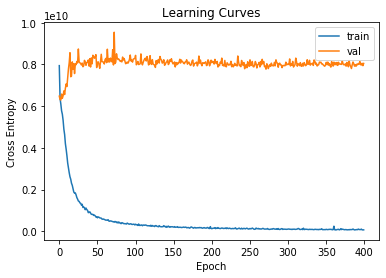

In [81]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(func_history.history['loss'], label='train')
plt.plot(func_history.history['val_loss'], label='val')
plt.figure(figsize=(20,10))
plt.legend()
plt.show()

In [82]:
mse = func_model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MSLE: %.3f, MAE: %.3f, MAPE: %.3f' % 
      (mse[1], mse[2], mse[4], mse[3], mse[5]))

MSE: 8046679552.000, RMSE: 89703.289, MSLE: 0.941, MAE: 41946.641, MAPE: 118.451


Text(0, 0.5, 'predicted values (test data)')

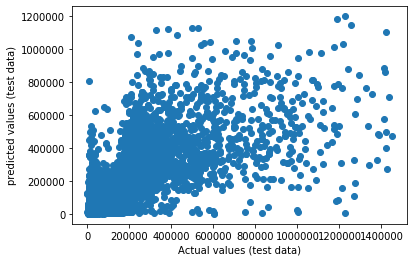

In [83]:
func_predictions=func_model.predict(X_test)
plt.plot(y_test, func_predictions, 'o')
plt.xlabel('Actual values (test data)')
plt.ylabel('predicted values (test data)')

In [92]:
r2_func = r2_score(y_test, func_predictions)
r2_func

0.5658299931758596

Text(0, 0.5, 'predicted values (train data)')

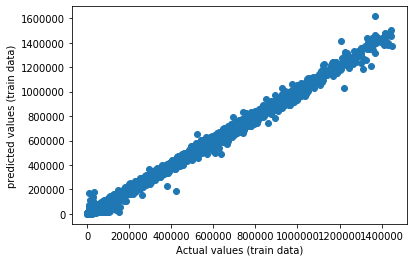

In [85]:
func_train_predictions=func_model.predict(X_train)
plt.plot(y_train, func_train_predictions, 'o')
plt.xlabel('Actual values (train data)')
plt.ylabel('predicted values (train data)')

In [86]:
func_predictions = func_predictions.flatten()

In [87]:
func_train_predictions = func_train_predictions.flatten()

In [ ]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': func_predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

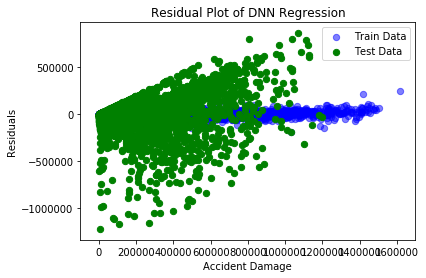

In [89]:
plt.scatter(func_train_predictions, func_train_predictions - y_train, c='b', s=40, alpha=0.5, label='Train Data')
plt.scatter(func_predictions, func_predictions - y_test, c='g', s=40, label='Test Data')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residual Plot of DNN Regression')
plt.ylabel('Residuals')
plt.xlabel('Accident Damage')
plt.legend()
plt.show()

## Polynomial Regression with Keras

In [90]:
poly = PolynomialFeatures(n_features)

In [100]:
n_features

142

In [91]:
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

KeyboardInterrupt: 

In [ ]:
inp = Input((n_features+1)) 
out = Dense(1)(inp)
model_poly = Model(inputs=inp, outputs=out)
model_poly.compile(optimizer=opt, loss="mse", metrics=metrics)

In [ ]:
model_poly.fit(X_train_poly, y_train, epochs=epochs)

In [ ]:
r2 = r2_score(Y_test, model_poly.predict(X_test_poly))

In [ ]:
polyerror = func_model.evaluate(X_test_poly, y_test, verbose=0)
print('R^2: %.3f, MSE: %.3f, RMSE: %.3f, MSLE: %.3f, MAE: %.3f, MAPE: %.3f' % 
      (r2, polyerror[1], polyerror[2], polyerror[4], polyerror[3], polyerror[5]))

In [ ]:
ax.scatter(X_train, y_train)
ax.plot(X_train, model_poly.predict(X_train_poly), color="red")

## Polynomial Regression with Scikit-Learn
* Polynomial Regression
* Polynomial Regression with Lasso => Lasso Regression schrumpft Koeffizienten um absoluten Wert -> ausselektieren.
* Polynomial Regression with Ridge (Ridge Regression or Tikhonov regularization) => Ridge Regression schrumpft Koeffizienten um relativen Wert.

In [ ]:
def poly_regression(X_train, X_test, Y_train, Y_test, reg):
    reg.fit(X_train, Y_train)
    y_pred = reg.predict(X_test)
    coef = reg.coef_
    intercept = reg.intercept_
    r2 = r2_score(Y_test, y_pred)
    MSA = mean_absolute_error(Y_test, y_pred) 
    MSE = mean_squared_error(Y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MSLE = mean_squared_log_error(Y_test, y_pred)
    
    return [r2, MSA, MSE, RMSE, MSLE]

In [ ]:
poly_reg = poly_regression(X_train_poly, Y_train, X_test_poly, Y_test, LinearRegression())

In [ ]:
poly_lasso_reg = poly_regression(X_train_poly, Y_train, X_test_poly, Y_test, Lasso())

In [ ]:
poly_ridge_reg = poly_regression(X_train_poly, Y_train, X_test_poly, Y_test, Ridge())

## Regression Results

In [ ]:
regressionresults = [
                                [
                                    r2_func ,mse[1], mse[2], mse[4], mse[3], mse[5]
                                ],
                                [
                                    r2_seq ,error[1], error[2], error[4], error[3], error[5]
                                ],
                                [
                                    r2, polyerror[1], polyerror[2], polyerror[4], polyerror[3], polyerror[5]
                                ],
                                [
                                    poly_reg[0],  poly_reg[2], poly_reg[3], poly_reg[4], poly_reg[1], np.NaN
                                ],
                                [
                                    poly_lasso_reg[0],  poly_lasso_reg[2], poly_lasso_reg[3], poly_lasso_reg[4], poly_lasso_reg[1], np.NaN
                                ],
                                [
                                    poly_ridge_reg[0],  poly_ridge_reg[2], poly_ridge_reg[3], poly_ridge_reg[4], poly_ridge_reg[1], np.NaN
                                ]
                            ]
reg_results = pd.DataFrame(regressionresults,columns=["R2", "MSE", "RMSE","MSLE", "MAE", "MAPE"], index=["Functional Neural Network Regression (Keras)", "Sequential Neural Network Regression (Keras)", "Polynomial Regression (Keras)", "Polynomial Regression (Scikit-Learn)", "Polynomial Regression with Lasso (Scikit-Learn)", "Polynomial Regression with Ridge (Scikit-Learn)"]).style.format("{:,.1f}")

In [ ]:
reg_results